# Movies – What Drives Box Office Success?

This notebook explores a movies dataset to answer a practical question:

> **Which movie characteristics are most strongly associated with box office revenue?**

I use this project to demonstrate an end-to-end analytics workflow:

1. Load and inspect the raw dataset  
2. Clean and prepare key features (budget, gross, votes, score, year)  
3. Explore correlations and visual relationships between variables  
4. Summarize insights with a short, business-friendly narrative

The focus is on **clarity of thinking and explanation**, not just code.


In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plot settings
plt.style.use("ggplot")
sns.set_theme()

# Display settings
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

DATA_PATH = "Desktop/Portfolio Projects/Movies Project/movies.csv"
RANDOM_STATE = 42

## 1. Load and Inspect the Data

First, I load the raw CSV and take a quick look at:

- Shape (rows, columns)
- Column names and data types
- A few sample records

This helps confirm that the file loaded correctly and guides later cleaning decisions.


In [3]:
def load_movies(path: str) -> pd.DataFrame:
    """Load the movies dataset from CSV."""
    df = pd.read_csv(path, parse_dates=["released"])
    return df


movies_raw = load_movies(DATA_PATH)

print(f"Shape: {movies_raw.shape}")
display(movies_raw.head())
movies_raw.info()

Shape: (7668, 16)


,name,rating,genre,year,released,year_new,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,1980-06-13,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,1980-07-02,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,1980-06-20,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,1980-07-02,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,1980-07-25,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   name      7668 non-null   object        
 1   rating    7591 non-null   object        
 2   genre     7668 non-null   object        
 3   year      7668 non-null   int64         
 4   released  7666 non-null   datetime64[ns]
 5   year_new  7668 non-null   int64         
 6   score     7665 non-null   float64       
 7   votes     7665 non-null   float64       
 8   director  7668 non-null   object        
 9   writer    7665 non-null   object        
 10  star      7667 non-null   object        
 11  country   7665 non-null   object        
 12  budget    5497 non-null   float64       
 13  gross     7479 non-null   float64       
 14  company   7651 non-null   object        
 15  runtime   7664 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(8)
memory

## 2. Data Quality Check & Cleaning Strategy

Before cleaning, I check how complete the data is.

Data cleaning questions I asked:

- Which columns have the most missing values?
- Can I safely drop some rows, or should I impute?
- Are there fields I know are unreliable (e.g., an incorrect `year` column)?

For this project, I:
- Focus on keeping rows where **`budget`, `gross`, `votes`, and `score`** are usable  
- Use the cleaned **`year_new`** (already added to the CSV) instead of the original `year` column  
- Convert numeric fields to integer types for consistency  
- Drop any remaining rows with minimal missing values and remove duplicates


In [4]:
def summarize_missing(df: pd.DataFrame) -> pd.Series:
    """Return percent of missing values to guide cleaning decisions."""
    missing_pct = (df.isna().mean() * 100).round(2)
    return missing_pct.sort_values(ascending=False)

# Check where the dataset is incomplete
missing_before = summarize_missing(movies_raw)
display(missing_before)


def clean_movies(df: pd.DataFrame) -> pd.DataFrame:
    """Clean dataset: handle missing values, convert types, drop duplicates."""
    df = df.copy()

    # Fill essential numeric fields to retain as many rows as possible
    for col in ["budget", "gross"]:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Drop rows with any remaining missing values
    df = df.dropna()

    # Convert key numeric fields to integers for consistency
    for col in ["budget", "gross", "votes"]:
        if col in df.columns:
            df[col] = df[col].astype("int64")

    # Use the cleaned year field if available
    if "year_new" in df.columns:
        df["year_new"] = df["year_new"].astype("int64")

    # Remove unreliable / redundant year column if present
    if "year" in df.columns:
        df = df.drop(columns=["year"])

    # Remove duplicate records
    df = df.drop_duplicates()

    return df


movies = clean_movies(movies_raw)

print(f"\nAfter cleaning: {movies.shape}")  # Ensure we retained enough rows
movies.info()

budget      28.31
gross        2.46
rating       1.00
company      0.22
runtime      0.05
country      0.04
writer       0.04
votes        0.04
score        0.04
released     0.03
star         0.01
director     0.00
year_new     0.00
year         0.00
genre        0.00
name         0.00
dtype: float64


After cleaning: (7574, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7574 entries, 0 to 7659
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   name      7574 non-null   object        
 1   rating    7574 non-null   object        
 2   genre     7574 non-null   object        
 3   released  7574 non-null   datetime64[ns]
 4   year_new  7574 non-null   int64         
 5   score     7574 non-null   float64       
 6   votes     7574 non-null   int64         
 7   director  7574 non-null   object        
 8   writer    7574 non-null   object        
 9   star      7574 non-null   object        
 10  country   7574 non-null   object        
 11  budget    7574 non-null   int64         
 12  gross     7574 non-null   int64         
 13  company   7574 non-null   object        
 14  runtime   7574 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(8)
memory usage: 946.8+ KB


## 3. Exploratory Data Analysis (EDA)

With a clean dataset, I start with a quick descriptive overview:

- Distribution summaries for key numeric features
- A check of the top-grossing movies
- A sense of typical budgets and scores

This builds intuition before looking at correlations.


In [7]:
# Select numeric columns that exist in the dataframe
numeric_cols = ["budget", "gross", "votes", "score", "runtime", "year_new"]
numeric_cols = [c for c in numeric_cols if c in movies.columns]

# Summary stats help understand scale & variation before deeper analysis
display(movies[numeric_cols].describe().T)

# Inspect the highest-grossing films to build intuition
display(
    movies
    .sort_values("gross", ascending=False)[
        ["name", "genre", "year_new", "budget", "gross", "score", "votes"]
    ]
    .head(10)
)

,count,mean,std,min,25%,50%,75%,max
budget,7574.0,2.580888e+07,3.872643e+07,0.0,0.00,12000000.0,32000000.0,3.560000e+08
gross,7574.0,7.730396e+07,1.648257e+08,0.0,4101905.75,19505692.0,74028959.0,2.847246e+09
votes,7574.0,8.894074e+04,1.640419e+05,35.0,9400.00,33000.0,94000.0,2.400000e+06
score,7574.0,6.389345e+00,9.684110e-01,1.9,5.80,6.5,7.1,9.300000e+00
runtime,7574.0,1.072911e+02,1.858472e+01,63.0,95.00,104.0,116.0,3.660000e+02
year_new,7574.0,2.000489e+03,1.158809e+01,1905.0,1991.00,2001.0,2010.0,2.020000e+03


,name,genre,year_new,budget,gross,score,votes
5445,Avatar,Action,2009,237000000,2847246203,7.8,1100000
7445,Avengers: Endgame,Action,2019,356000000,2797501328,8.4,903000
3045,Titanic,Drama,1997,200000000,2201647264,7.8,1100000
6663,Star Wars: Episode VII - The Force Awakens,Action,2015,245000000,2069521700,7.8,876000
7244,Avengers: Infinity War,Action,2018,321000000,2048359754,8.4,897000
7480,The Lion King,Animation,2019,260000000,1670727580,6.9,222000
6653,Jurassic World,Action,2015,150000000,1670516444,7.0,593000
6043,The Avengers,Action,2012,220000000,1518815515,8.0,1300000
6646,Furious 7,Action,2015,190000000,1515341399,7.1,370000
7494,Frozen II,Animation,2019,150000000,1450026933,6.8,148000


## 4. Correlation Analysis

Next, I quantify how strongly different features move together.

I start with:

- A **numeric-only correlation matrix** for budget, gross, votes, score, runtime, and year
- Then build an **encoded version** of the dataset to include categorical fields (genre, company, etc.)

I’m especially interested in:

- `budget` ↔ `gross`  
- `votes` ↔ `gross`  
- `score` ↔ `gross` and `score` ↔ `votes`


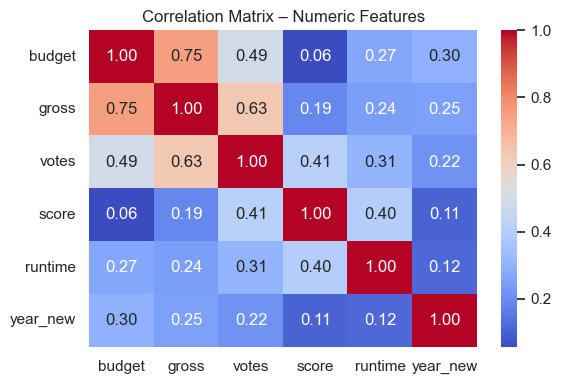

,budget,gross,votes,score,runtime,year_new
budget,1.000000,0.750562,0.485301,0.056781,0.270042,0.298407
gross,0.750562,1.000000,0.632987,0.188259,0.244942,0.251542
votes,0.485301,0.632987,1.000000,0.411931,0.309366,0.218024
score,0.056781,0.188259,0.411931,1.000000,0.400574,0.105901
runtime,0.270042,0.244942,0.309366,0.400574,1.000000,0.116783
year_new,0.298407,0.251542,0.218024,0.105901,0.116783,1.000000


In [9]:
# Compute correlations across numeric features only
corr_numeric = movies[numeric_cols].corr()

# Visual heatmap to quickly spot strong relationships
plt.figure(figsize=(6, 4))
sns.heatmap(corr_numeric, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix – Numeric Features")
plt.tight_layout()
plt.show()

corr_numeric  # Also display raw matrix for reference

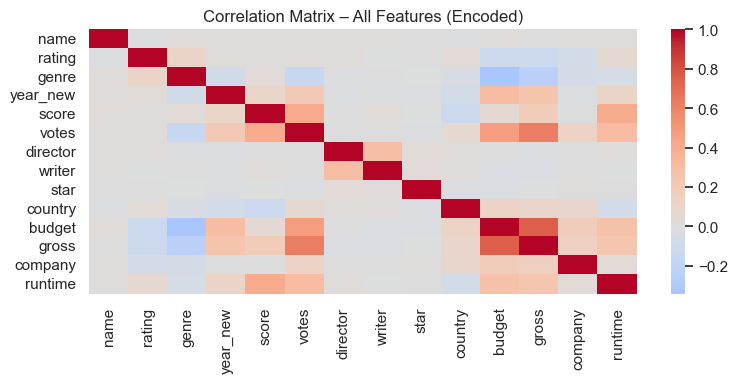

,feature_1,feature_2,correlation
85,budget,gross,0.750562
60,votes,gross,0.632987


In [17]:
def numerize_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """Encode object columns numerically to include them in correlations."""
    df_num = df.copy()
    for col in df_num.select_dtypes(include="object").columns:
        df_num[col] = df_num[col].astype("category").cat.codes
    return df_num

# Create fully numeric version of dataset
movies_num = numerize_categoricals(movies)

# Correlation across all encoded fields
corr_all = movies_num.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr_all, cmap="coolwarm", center=0)
plt.title("Correlation Matrix – All Features (Encoded)")
plt.tight_layout()
plt.show()


def top_correlation_pairs_df(corr_matrix: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """Return a DataFrame of feature pairs and their correlation values."""
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_pairs = corr_matrix.where(mask).stack().reset_index()
    corr_pairs.columns = ["feature_1", "feature_2", "correlation"]
    corr_pairs = corr_pairs[corr_pairs["correlation"].abs() > threshold]
    return corr_pairs.sort_values("correlation", key=lambda s: s.abs(), ascending=False)

top_corr_df = top_correlation_pairs_df(corr_all, threshold=0.5)
display(top_corr_df.head(20))

### Correlation Highlights

From the correlation outputs:

- **Budget vs Gross** shows one of the strongest positive relationships → higher budgets tend to be associated with higher box office revenue.
- **Votes vs Gross** is also strongly positive → movies that more people watch and rate tend to earn more.
- **Score vs Votes** is moderately positive → better-rated movies often attract more engagement, but rating alone is not the main driver of revenue.
- Other relationships (e.g., runtime, year) are weaker and less central to the revenue story.

To make this more concrete, I visualize some of these relationships directly.


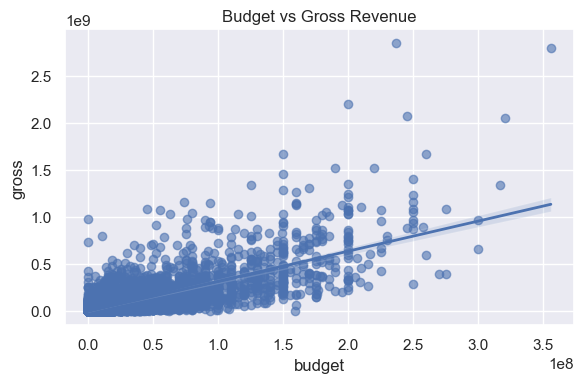

In [13]:
plt.figure(figsize=(6, 4))
sns.regplot(
    data=movies,
    x="budget",
    y="gross",
    scatter_kws={"alpha": 0.6},
    line_kws={"linewidth": 2},
)
plt.title("Budget vs Gross Revenue")
plt.tight_layout()
plt.show()

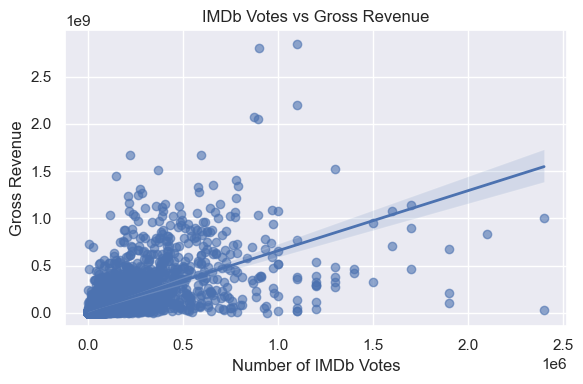

In [23]:
plt.figure(figsize=(6, 4))
sns.regplot(
    data=movies,
    x="votes",
    y="gross",
    scatter_kws={"alpha": 0.6},
    line_kws={"linewidth": 2},
)
plt.title("IMDb Votes vs Gross Revenue")
plt.xlabel("Number of IMDb Votes")
plt.ylabel("Gross Revenue")
plt.tight_layout()
plt.show()

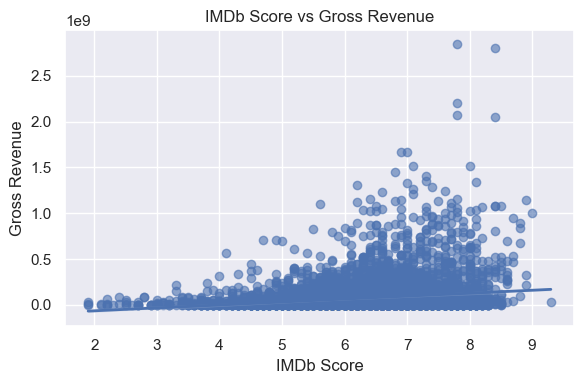

In [25]:
plt.figure(figsize=(6, 4))
sns.regplot(
    data=movies,
    x="score",
    y="gross",
    scatter_kws={"alpha": 0.6},
    line_kws={"linewidth": 2},
)
plt.title("IMDb Score vs Gross Revenue")
plt.xlabel("IMDb Score")
plt.ylabel("Gross Revenue")
plt.tight_layout()
plt.show()

## 6. Genre-Level Patterns

Finally, I look at patterns by **genre**:

- How budgets and gross revenues differ across genres  
- How average scores and votes vary by genre  

This helps show how financial and audience profiles differ across types of movies.

,score,votes,budget,gross
genre,,,,
Animation,6.8,128407.7,63302604.8,239188847.6
Family,6.5,75340.0,20450000.0,215787647.6
Action,6.2,141264.1,48876290.9,143339860.4
Adventure,6.3,101223.6,35300610.3,107758471.9
Mystery,6.7,230125.8,27095000.0,101183527.7
Biography,7.0,91217.6,18162092.9,47211448.7
Horror,5.8,68831.5,10628434.0,45730737.7
Comedy,6.2,54609.6,15307301.0,43568332.5
Crime,6.7,91747.1,16630963.4,39181473.0


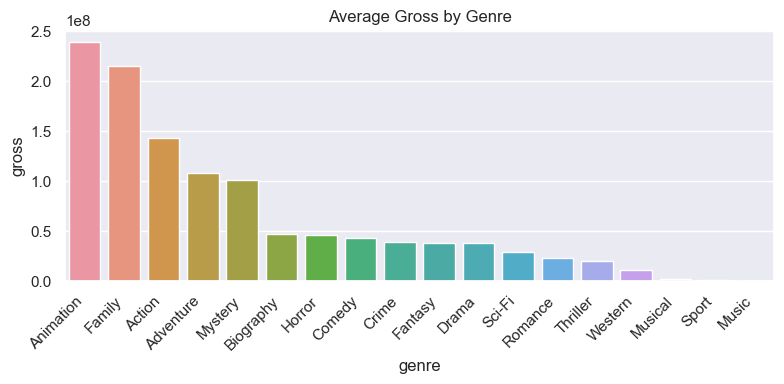

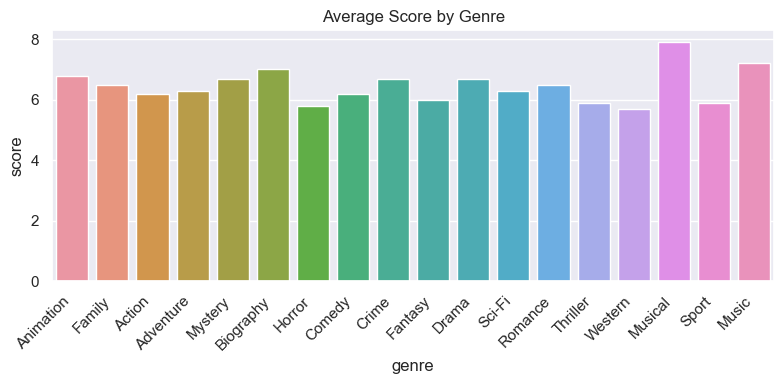

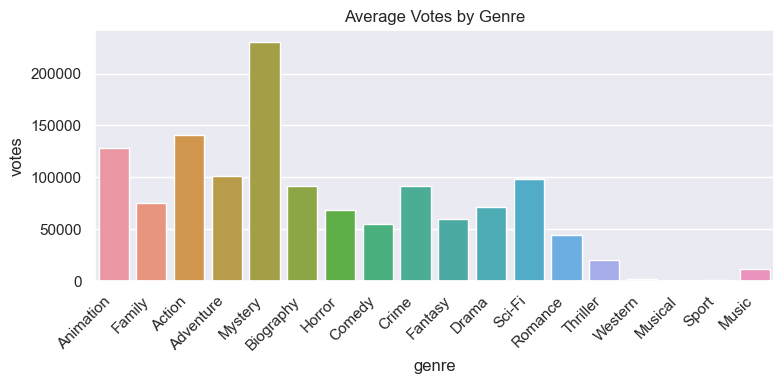

In [15]:
# Compute average performance metrics per genre
genre_group = (
    movies.groupby("genre")[["score", "votes", "budget", "gross"]]
    .mean()
    .round(1)
    .sort_values("gross", ascending=False)
)

display(genre_group.head(10))  # Show top-performing genres


def plot_genre_metric(metric: str):
    """Generic bar chart to compare genres on a chosen metric."""
    if metric not in genre_group.columns:
        raise ValueError(f"Metric '{metric}' not found.")

    plt.figure(figsize=(8, 4))
    sns.barplot(
        x=genre_group.index,
        y=genre_group[metric],
    )
    plt.title(f"Average {metric.title()} by Genre")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Visual comparisons across genres
plot_genre_metric("gross")
plot_genre_metric("score")
plot_genre_metric("votes")

## 7. Conclusion

In this analysis, I:

- Cleaned and prepared a real-world movies dataset
- Explored descriptive statistics for key financial and engagement metrics
- Quantified relationships using correlation analysis
- Visualized how budget, popularity, and ratings relate to box office performance
- Compared average performance by genre

**Key takeaways:**

- Higher budgets are strongly associated with higher box office revenue, though there is still considerable risk and variability.
- Audience reach (IMDb votes) is a strong predictor of revenue and appears more important than the average rating score alone.
- Genres like Action, Adventure, and Animation tend to operate with higher budgets and higher average gross, whereas Drama and Comedy are more frequent but usually lower-budget, lower-gross.

If I were to extend this project, I would:
- Build a simple **predictive model** (e.g., linear regression) to estimate gross from a subset of features  
- Adjust budget and gross for **inflation** to compare across years  
- Analyze performance by **studio / production company** for a more business-oriented perspective
